# Diamond Price Prediction Model

## Project Overview

The Diamond Price Prediction project aims to build a machine learning model that accurately estimates the price of a diamond based on its attributes such as carat, cut, color, clarity, depth, and dimensions. The project will involve data collection, preprocessing, feature engineering, model training, and deployment through a Streamlit web application.

Link to Dataset: https://www.kaggle.com/datasets/willianoliveiragibin/type-of-the-diamond

## Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
import os

from sklearn.preprocessing import LabelEncoder

## Data Ingestion

In [24]:
# Download latest version
path = kagglehub.dataset_download("willianoliveiragibin/type-of-the-diamond")

print("Path to dataset files:", path)

Path to dataset files: /Users/reema14a/.cache/kagglehub/datasets/willianoliveiragibin/type-of-the-diamond/versions/1


In [25]:
os.listdir(path)[0]

'type of the Diamond new.csv'

In [26]:
dataset = pd.read_csv(path + '/' + os.listdir(path)[0])

In [27]:
dataset.shape

(53940, 10)

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cut            53940 non-null  object 
 1   color          53940 non-null  object 
 2   clarity        53940 non-null  object 
 3   carat          53940 non-null  float64
 4   depth          53940 non-null  float64
 5   table          53940 non-null  float64
 6   price          53940 non-null  int64  
 7   x (Premium)    53940 non-null  float64
 8   z (Very Good)  53940 non-null  float64
 9   y (Good)       53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


*   **carat**: indicates the weight of the diamond 
*   **cut**: determines its shine with categories such as `ideal`, `premium`, `good`, `very good` and `fair`  
*   **color**: ranges from `D` to `J` affecting the visual appeal of the diamond 
*   **clarity**: describes the internal purity of the diamond with classifications like `SI2`, `SI1`, `VS1`, `VS2`, `VVS2`, `VVS1` and `I1` 
*   **depth**: represents the diamond’s depth percentage 
*   **table**: refers to the flat facet on its surface which is the large flat area visible from above 
*   **x**: denotes the width of the diamond 
*   **y**: denotes the length of the diamond 
*   **z**: denotes the height of the diamond 
*   **price**: indicates the cost of the diamond in USD

In [29]:
dataset.head(5)

,cut,color,clarity,carat,depth,table,price,x (Premium),z (Very Good),y (Good)
0,Fair,E,VS2,0.22,65.1,61.0,337,3.87,2.49,3.78
1,Fair,E,SI2,0.86,55.1,69.0,2757,6.45,3.52,6.33
2,Fair,F,SI2,0.96,66.3,62.0,2759,6.27,4.07,5.95
3,Fair,F,VS2,0.70,64.5,57.0,2762,5.57,3.58,5.53
4,Fair,F,VS2,0.70,65.3,55.0,2762,5.63,3.66,5.58


## EDA

In [30]:
# Check for null values
dataset.isnull().sum()

cut              0
color            0
clarity          0
carat            0
depth            0
table            0
price            0
x (Premium)      0
z (Very Good)    0
y (Good)         0
dtype: int64

***No null* values**

In [31]:
features = ['cut', 'color', 'clarity']

for x in features:
    print('-----------------')
    print('\033[1m' + x + '\033[0m')
    print('-----------------')
    print(dataset[x].value_counts())

-----------------
cut
-----------------
cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64
-----------------
color
-----------------
color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64
-----------------
clarity
-----------------
clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64


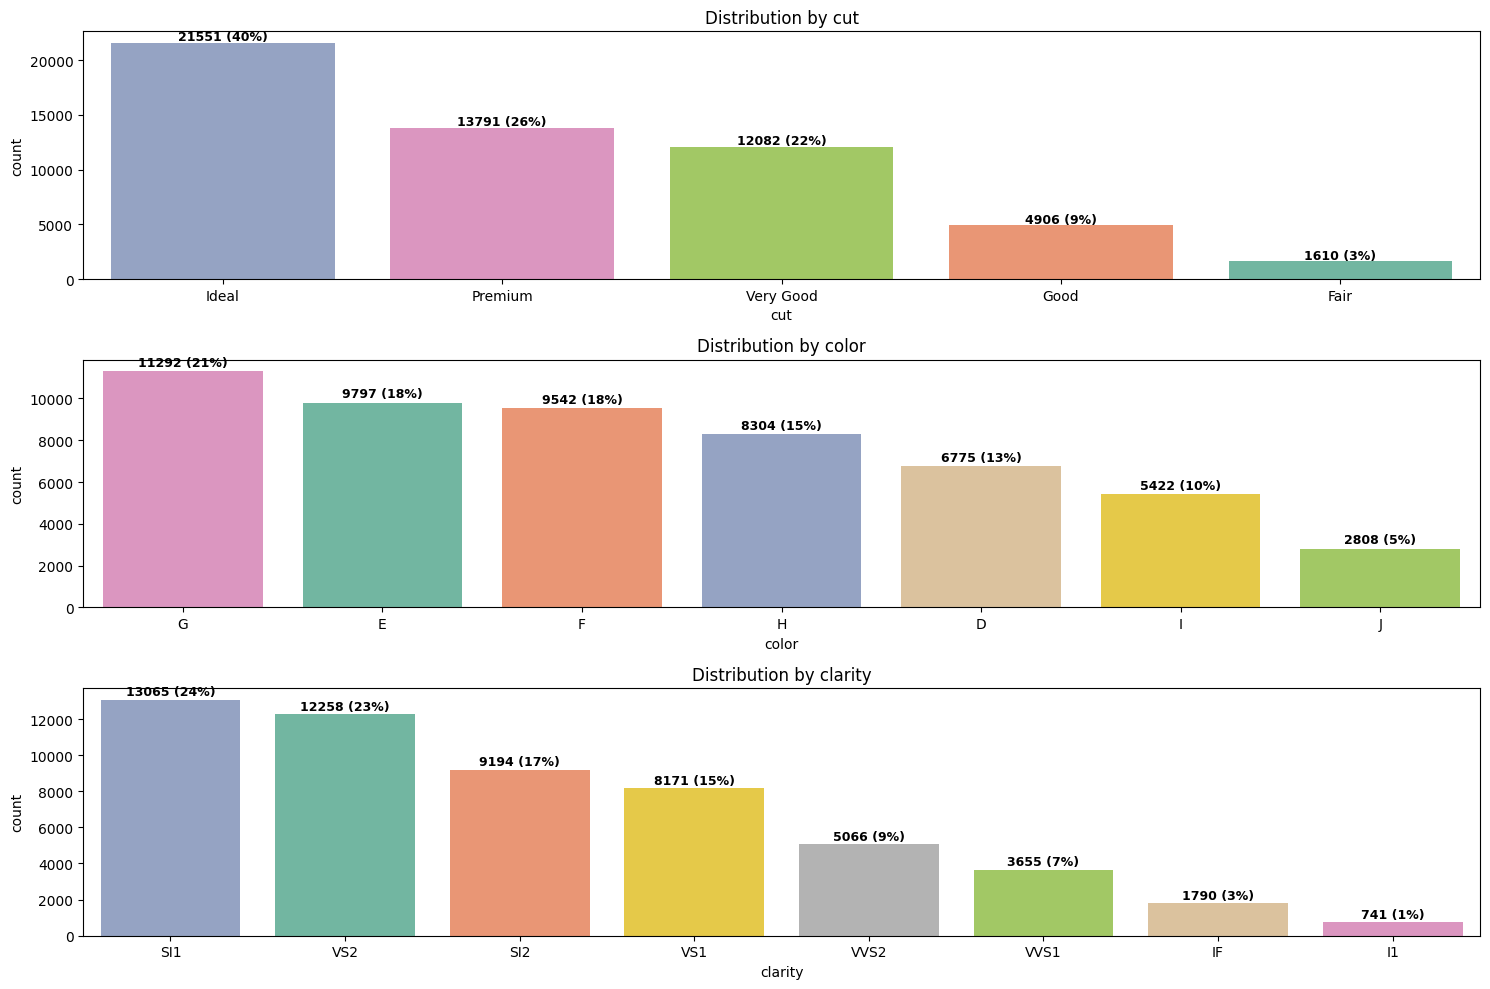

In [32]:
plt.figure(figsize=(15,10))

features = ['cut', 'color', 'clarity']

for index, feature in enumerate(features):
    abs_values = dataset[feature].value_counts(ascending=False)
    rel_values = dataset[feature].value_counts(ascending=False, normalize=True).values * 100
    lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]


    plt.subplot(3, 1, index + 1)
    ax = sns.countplot(data = dataset, 
                    x = feature, 
                    order=abs_values.index,
                    hue = feature, 
                    palette = 'Set2')

    # Extract bars in sorted order
    bars = sorted(ax.patches, key=lambda bar: bar.get_x())  # Sort bars by x-position

    # Annotate each bar with corresponding label
    for bar, lbl in zip(bars, lbls):  
        ax.text(bar.get_x() + bar.get_width()/2,  # X-coordinate (center of bar)
                bar.get_height() + 250,            # Y-coordinate (above bar)
                lbl,                              # Label text
                ha='center',                      # Center alignment
                fontsize=9, 
                fontweight='bold')
    
    plt.title('Distribution by ' + feature)
plt.tight_layout()
plt.show()

In [33]:
dataset.describe()

,carat,depth,table,price,x (Premium),z (Very Good),y (Good)
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,3.538734,5.734526
std,0.474011,1.432621,2.234491,3989.439738,1.121761,0.705699,1.142135
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,2.910000,4.720000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,3.530000,5.710000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,4.040000,6.540000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,31.800000,58.900000


In [34]:
#sns.pairplot(dataset, hue="cut", diag_kind="kde", palette="Set2")
#plt.show()

### Label Encoding

Since using Random Forest, XGBoost → Label Encoding is better. \
If using Linear Regression, SVM → One-Hot Encoding is better

In [35]:
#Using LabelEncoding to convert 
le = LabelEncoder()

features = ['cut', 'color', 'clarity']

for index, feature in enumerate(features):
    dataset[feature + '_en'] = le.fit_transform(dataset[feature])    
    

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cut            53940 non-null  object 
 1   color          53940 non-null  object 
 2   clarity        53940 non-null  object 
 3   carat          53940 non-null  float64
 4   depth          53940 non-null  float64
 5   table          53940 non-null  float64
 6   price          53940 non-null  int64  
 7   x (Premium)    53940 non-null  float64
 8   z (Very Good)  53940 non-null  float64
 9   y (Good)       53940 non-null  float64
 10  cut_en         53940 non-null  int64  
 11  color_en       53940 non-null  int64  
 12  clarity_en     53940 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 5.4+ MB


In [37]:
df = dataset.copy(deep=True)

In [38]:
# Dropping original categorical columns as we have the encoded values now
df.drop(columns= ['cut', 'color', 'clarity'], inplace = True)

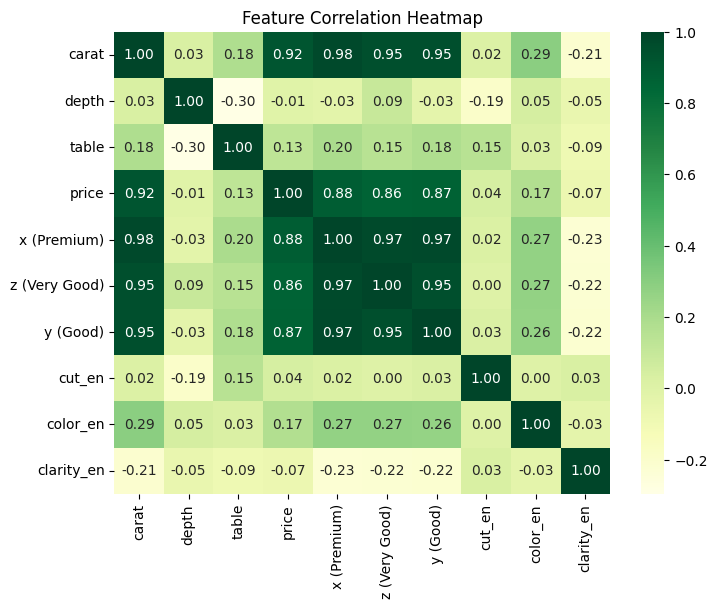

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cut            53940 non-null  object 
 1   color          53940 non-null  object 
 2   clarity        53940 non-null  object 
 3   carat          53940 non-null  float64
 4   depth          53940 non-null  float64
 5   table          53940 non-null  float64
 6   price          53940 non-null  int64  
 7   x (Premium)    53940 non-null  float64
 8   z (Very Good)  53940 non-null  float64
 9   y (Good)       53940 non-null  float64
 10  cut_en         53940 non-null  int64  
 11  color_en       53940 non-null  int64  
 12  clarity_en     53940 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 5.4+ MB


/var/folders/s9/jq10pq213hvgwhd8sxxh3lsc0000gn/T/ipykernel_73332/3907112780.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dataset, x='cut', y='price', palette="Set3")


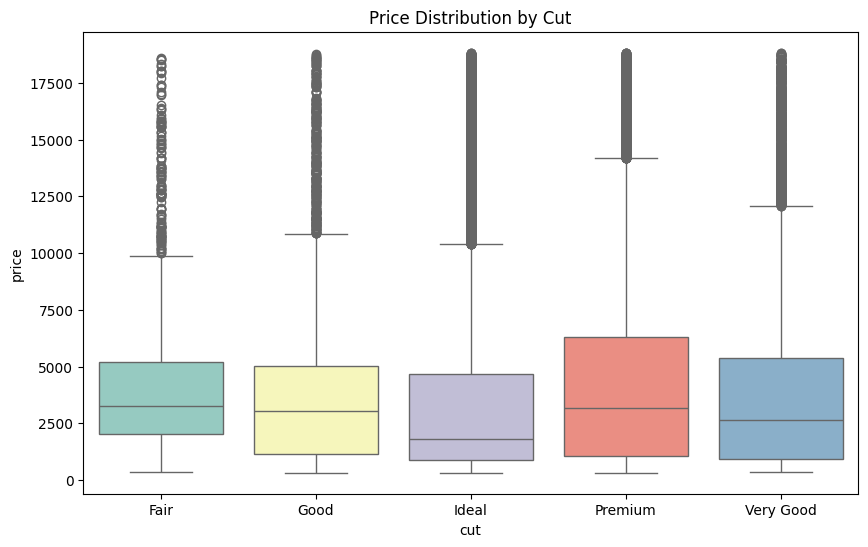

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x='cut', y='price', palette="Set3")
plt.title("Price Distribution by Cut")
plt.show()